# FTTransformer，一个很能打的模型

FTTransformer是一个可以用于结构化(tabular)数据的分类和回归任务的模型。

FT 即 Feature Tokenizer的意思，把结构化数据中的离散特征和连续特征都像单词一样编码成一个向量。

从而可以像对text数据那样 应用 Transformer对 Tabular数据进行特征抽取。

值得注意的是，它对Transformer作了一些微妙的改动以适应 Tabular数据。

例如：去除第一个Transformer输入的LayerNorm层，仿照BERT的设计增加了output token(CLS token) 与features token 一起进行进入Transformer参与注意力计算。

参考: https://paperswithcode.com/method/ft-transformer

本范例我们使用Covertype数据集，它的目标是预测植被覆盖类型，是一个七分类问题。

公众号**算法美食屋**后台回复关键词：torchkeras，获取本文notebook源码和所用Covertype数据集下载链接。



## 一，准备数据

In [76]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split

file_path = "covertype.parquet"
dfdata = pd.read_parquet(file_path)

cat_cols = ['Wilderness_Area', 'Soil_Type']
num_cols = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
target_col = 'Cover_Type'

print("dfdata.shape = ",dfdata.shape)
print("target_col = ", target_col)
print('cat_cols = ', cat_cols)  
print('num_cols = ', num_cols[:3]+['...'])

dftmp, dftest_raw = train_test_split(dfdata, random_state=42, test_size=0.2)
dftrain_raw, dfval_raw = train_test_split(dftmp, random_state=42, test_size=0.2)

print("len(dftrain) = ",len(dftrain_raw))
print("len(dfval) = ",len(dfval_raw))
print("len(dftest) = ",len(dftest_raw))


dfdata.shape =  (581012, 13)
target_col =  Cover_Type
cat_cols =  ['Wilderness_Area', 'Soil_Type']
num_cols =  ['Elevation', 'Aspect', 'Slope', '...']
len(dftrain) =  371847
len(dfval) =  92962
len(dftest) =  116203


In [77]:
from torchkeras.tabular import TabularPreprocessor
from sklearn.preprocessing import OrdinalEncoder

#特征工程
pipe = TabularPreprocessor(cat_features = cat_cols, 
                           embedding_features=cat_cols)
encoder = OrdinalEncoder()

dftrain = pipe.fit_transform(dftrain_raw.drop(target_col,axis=1))
dftrain[target_col] = encoder.fit_transform(
    dftrain_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dfval = pipe.transform(dfval_raw.drop(target_col,axis=1))
dfval[target_col] = encoder.transform(
    dfval_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dftest = pipe.transform(dftest_raw.drop(target_col,axis=1))
dftest[target_col] = encoder.transform(
    dftest_raw[target_col].values.reshape(-1,1)).astype(np.int32)


In [78]:
from torchkeras.tabular import TabularDataset
from torch.utils.data import Dataset,DataLoader 

def get_dataset(dfdata):
    return TabularDataset(
                data = dfdata,
                task = 'classification',
                target = [target_col],
                continuous_cols = pipe.get_numeric_features(),
                categorical_cols = pipe.get_embedding_features()
        )

def get_dataloader(ds,batch_size=1024,num_workers=0,shuffle=False):
    dl = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=False,
        )
    return dl 
    
ds_train = get_dataset(dftrain)
ds_val = get_dataset(dfval)
ds_test = get_dataset(dftest)

dl_train = get_dataloader(ds_train,shuffle=True)
dl_val = get_dataloader(ds_val,shuffle=False)
dl_test = get_dataloader(ds_test,shuffle=False)


In [79]:
for batch in dl_train:
    break

## 二，定义模型

In [98]:
from torchkeras.tabular.models import FTTransformerConfig,FTTransformerModel

model_config = FTTransformerConfig(
    task="classification",
    num_attn_blocks=3
)

config = model_config.merge_dataset_config(ds_train)
net = FTTransformerModel(config = config)

#初始化参数
net.reset_weights()
net.data_aware_initialization(dl_train)

print(net.backbone.output_dim)
print(net.hparams.output_dim)


32
7


In [99]:
output = net.forward(batch)
loss = net.compute_loss(output,batch['target'])
print(loss)

tensor(1.8233, grad_fn=<AddBackward0>)


## 三，训练模型

In [101]:
from torchkeras import KerasModel 
from torchkeras.tabular import StepRunner 
KerasModel.StepRunner = StepRunner 


In [102]:
import torch 
from torch import nn 
class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        targets = targets.reshape(-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total

In [103]:
keras_model = KerasModel(net,
                   loss_fn=None,
                   optimizer = torch.optim.AdamW(net.parameters(),lr = 1e-3),
                   metrics_dict = {"acc":Accuracy()}
                   )

<<<<<< ⚡️ cuda is used >>>>>>


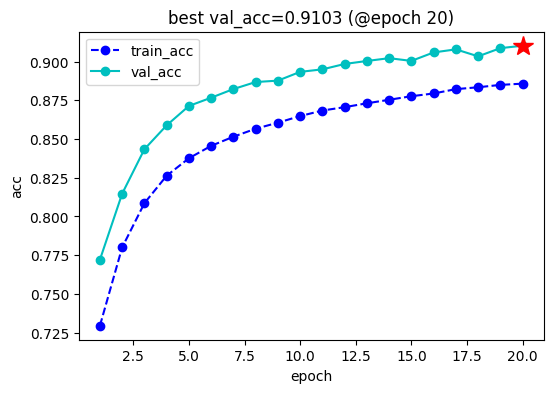

,epoch,train_loss,train_acc,lr,val_loss,val_acc
0,1,0.648322,0.729405,0.001,0.526820,0.772047
1,2,0.510666,0.780004,0.001,0.431836,0.814720
2,3,0.448462,0.808580,0.001,0.376994,0.843441
3,4,0.410837,0.826316,0.001,0.343128,0.858878
4,5,0.385901,0.837603,0.001,0.317283,0.871399
5,6,0.368809,0.845625,0.001,0.301425,0.876735
6,7,0.355265,0.851530,0.001,0.291782,0.882317
7,8,0.343094,0.856686,0.001,0.282184,0.886857
8,9,0.334615,0.860593,0.001,0.273995,0.887761
9,10,0.325979,0.864864,0.001,0.264454,0.893430


In [104]:
keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='checkpoint',
    epochs=20,
    patience=10,
    monitor="val_acc", 
    mode="max",
    plot = True,
    wandb = False
)

## 四，评估模型

In [105]:
keras_model.evaluate(dl_train)

100%|██████████████████████████████| 364/364 [00:09<00:00, 37.22it/s, val_acc=0.917, val_loss=0.208]


{'val_loss': 0.20806533740935745, 'val_acc': 0.9165651202201843}

In [106]:
keras_model.evaluate(dl_val)

100%|█████████████████████████████████| 91/91 [00:02<00:00, 40.27it/s, val_acc=0.91, val_loss=0.222]


{'val_loss': 0.22164690216164012, 'val_acc': 0.9103181958198547}

In [107]:
keras_model.evaluate(dl_test)

100%|███████████████████████████████| 114/114 [00:02<00:00, 41.57it/s, val_acc=0.911, val_loss=0.22]


{'val_loss': 0.22033428426897317, 'val_acc': 0.9109489321708679}

## 五，使用模型

In [108]:
from tqdm import tqdm 
net = net.cpu()
net.eval()
preds = []
with torch.no_grad():
    for batch in tqdm(dl_test):
        preds.append(net.predict(batch))
    

100%|██████████| 114/114 [00:15<00:00,  7.39it/s]


In [109]:
yhat_list = [yd.argmax(dim=-1).tolist() for yd in preds]
yhat = []
for yd in yhat_list:
    yhat.extend(yd)
yhat = encoder.inverse_transform(np.array(yhat).reshape(-1,1))

In [110]:
dftest_raw = dftest_raw.rename(columns = {target_col: 'y'})
dftest_raw['yhat'] = yhat

In [111]:
from sklearn.metrics import classification_report
print(classification_report(y_true = dftest_raw['y'],y_pred = dftest_raw['yhat']))

              precision    recall  f1-score   support

           1       0.90      0.91      0.91     42557
           2       0.92      0.92      0.92     56500
           3       0.92      0.90      0.91      7121
           4       0.85      0.82      0.83       526
           5       0.78      0.75      0.77      1995
           6       0.84      0.82      0.83      3489
           7       0.92      0.91      0.91      4015

    accuracy                           0.91    116203
   macro avg       0.88      0.86      0.87    116203
weighted avg       0.91      0.91      0.91    116203



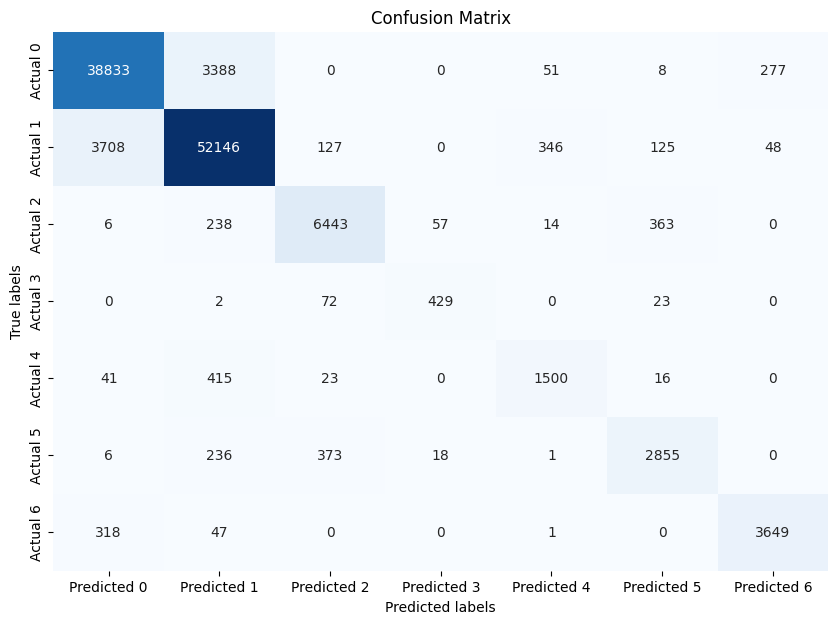

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# 计算混淆矩阵
cm = confusion_matrix(dftest_raw['y'], dftest_raw['yhat'])

# 将混淆矩阵转换为DataFrame
df_cm = pd.DataFrame(cm, index=['Actual {}'.format(i) for i in range(cm.shape[0])],
                     columns=['Predicted {}'.format(i) for i in range(cm.shape[1])])

# 使用seaborn绘制混淆矩阵
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 六，保存模型

最佳模型权重已经保存在ckpt_path = 'checkpoint'位置了。

In [113]:
net.load_state_dict(torch.load('checkpoint'))

<All keys matched successfully>

## 七，与LightGBM对比

In [115]:
import pandas as pd 
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score 

dftmp, dftest_raw = train_test_split(dfdata, random_state=42, test_size=0.2)
dftrain_raw, dfval_raw = train_test_split(dftmp, random_state=42, test_size=0.2)

dftrain = dftrain_raw.copy()
dfval = dfval_raw.copy()
dftest = dftest_raw.copy()

target_col = 'Cover_Type'
cat_cols = ['Wilderness_Area', 'Soil_Type']

encoder = OrdinalEncoder()

dftrain[target_col] = encoder.fit_transform(dftrain[target_col].values.reshape(-1,1)) 
dfval[target_col] = encoder.transform(dfval[target_col].values.reshape(-1,1))
dftest[target_col] = encoder.transform(dftest[target_col].values.reshape(-1,1))

for col in cat_cols:
    dftrain[col] = dftrain[col].astype(int)
    dfval[col] = dfval[col].astype(int)
    dftest[col] = dftest[col].astype(int)

ds_train = lgb.Dataset(dftrain.drop(columns=[target_col]), label=dftrain[target_col],categorical_feature=cat_cols)
ds_val = lgb.Dataset(dfval.drop(columns=[target_col]), label=dfval[target_col],categorical_feature=cat_cols)
ds_test = lgb.Dataset(dftest.drop(columns=[target_col]), label=dftest[target_col],categorical_feature=cat_cols)


import lightgbm as lgb

params = {
    'n_estimators':500,
    'boosting_type': 'gbdt',
    'objective':'multiclass',
    'num_class': 7,  # 类别数量
    'metric': 'multi_logloss', 
    'learning_rate': 0.01,
    'verbose': 1,
    'early_stopping_round':50
}
model = lgb.train(params, ds_train, 
        valid_sets=[ds_val], 
        valid_names=['validate']
        )

y_pred_val = model.predict(dfval.drop(target_col,axis = 1), num_iteration=model.best_iteration)
y_pred_val = np.argmax(y_pred_val, axis=1)

y_pred_test = model.predict(dftest.drop(target_col,axis = 1), num_iteration=model.best_iteration)
y_pred_test = np.argmax(y_pred_test, axis=1)

val_score = accuracy_score(dfval[target_col], y_pred_val)
test_score = accuracy_score(dftest[target_col], y_pred_test) 

print('val_score = ',val_score)
print('test_score = ' , test_score)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2219
[LightGBM] [Info] Number of data points in the train set: 371847, number of used features: 12
[LightGBM] [Info] Start training from score -1.009334
[LightGBM] [Info] Start training from score -0.717530
[LightGBM] [Info] Start training from score -2.789050
[LightGBM] [Info] Start training from score -5.354306
[LightGBM] [Info] Start training from score -4.127223
[LightGBM] [Info] Start training from score -3.510637
[LightGBM] [Info] Start training from score -3.341909
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	validate's multi_logloss: 0.408343
val_score =  0.8321464684494739
test_score =  0.8329389086340284


In [ ]:
#测试集准确率对比数据
{'FTTransformer': 0.91481286,
 'AutoInt':0.8217,
 'CategoryEmbeddingModel':0.85238,
 'GANDALFModel':0.897670,
 'GatedAdditiveTreeEnsembleModel':0.9008,
 'LGB':0.8329
}